In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [15]:
DATA_DIR = f'Sleep_dataset.csv'
DF=pd.read_csv(DATA_DIR)
DF['Sleep Disorder'] = DF['Sleep Disorder'].replace(np.nan, 'None')

**Dataset Columns:**
1.   **Person ID**: An identifier for each individual.
2.   **Gender (Male/Female)**: The gender of the person.
3.   **Age**: The age of the person in years.
Occupation: The occupation or profession of the person.
4.   **Sleep Duration (hours)**: The number of hours the person sleeps per day.
5.   **Quality of Sleep (scale: 1-10)**: A subjective rating of the quality of sleep, ranging from 1 to 10.
6.   **Physical Activity Level (minutes/day)**: The number of minutes the person engages in physical activity daily.
7.   **Stress Level (scale: 1-10)**: A subjective rating of the stress level experienced by the person, ranging from 1 to 10.
8.   **BMI Category**: The BMI category of the person (e.g., Underweight, Normal, Overweight).
9.   **Blood Pressure (systolic/diastolic)**: The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.
10.   **Heart Rate (bpm)**: The resting heart rate of the person in beats per minute.
11.  **Daily Steps**: The number of steps the person takes per day.
12.   **Sleep Disorder**: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).


In [16]:
DF.isna().sum()
DF.head()
DF.info()
DF.describe()
#number of values in each column
DF.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


Person ID                  374
Gender                       2
Age                         31
Occupation                  11
Sleep Duration              27
Quality of Sleep             6
Physical Activity Level     16
Stress Level                 6
BMI Category                 4
Blood Pressure              25
Heart Rate                  19
Daily Steps                 20
Sleep Disorder               3
dtype: int64

**Data Pre-Processing


**PCA


In [17]:
new_df = DF.copy(deep=True)

In [18]:
features = ['Age', 'Stress Level', 'Heart Rate', 'Physical Activity Level', 'Daily Steps']
pca_df = new_df.loc[:, features]

# Standardize
pca_df = (pca_df - pca_df.mean(axis=0)) / pca_df.std(axis=0)
# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(pca_df)

# Convert to DataFrame for easy interpretation
pca_scores = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Explained Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("Principal Component Scores:\n", pca_scores.head())

Explained Variance Ratio: [0.38439292 0.36012186 0.15745925 0.08272543 0.01530054]
Cumulative Variance Ratio: [0.38439292 0.74451478 0.90197402 0.98469946 1.        ]
Principal Component Scores:
         PC1       PC2       PC3       PC4       PC5
0  1.249366 -2.423032  0.001468 -1.326875  0.137605
1  2.760950  0.354019 -1.085173  0.476525  0.965483
2  2.760950  0.354019 -1.085173  0.476525  0.965483
3  2.735617 -3.691344  1.432202 -1.403149  0.329976
4  2.735617 -3.691344  1.432202 -1.403149  0.329976


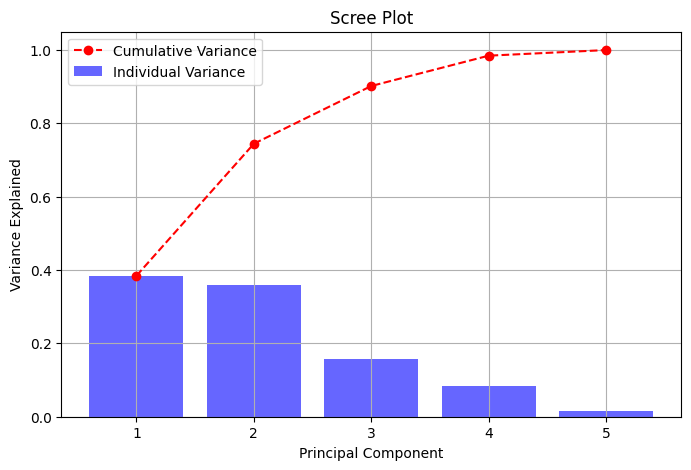

In [19]:
# Get the loadings (eigenvectors)
loadings = pca.components_.T

# Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color="b", label="Individual Variance")
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker="o", linestyle="--", color="r", label="Cumulative Variance")

plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot")
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()

plt.show()

In [20]:
pca_df.columns

Index(['Age', 'Stress Level', 'Heart Rate', 'Physical Activity Level',
       'Daily Steps'],
      dtype='object')

### OLS Regression

In [21]:
X = pca_df.drop(columns=['Stress Level'])  # Exclude target variable
y = pca_df['Stress Level']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [22]:
X = sm.add_constant(X)

# Full Model
model = sm.OLS(y, X).fit()

# Stepwise Backward Elimination
def backward_stepwise_selection(X, y, alpha=0.05):
    model = sm.OLS(y, X).fit()
    while True:
        p_values = model.pvalues.drop("const")  
        max_p = p_values.max()  
        if max_p < alpha:
            break  # Stop 
        else:
            feature_to_remove = p_values.idxmax()  # Feature with highest p-value
            print(feature_to_remove)
            X = X.drop(columns=[feature_to_remove])  
            model = sm.OLS(y, X).fit()  # Refit model
    return model

#Backward Stepwise Regression
final_model = backward_stepwise_selection(X, y)

print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Stress Level   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     258.4
Date:                Wed, 12 Feb 2025   Prob (F-statistic):          1.39e-105
Time:                        15:27:12   Log-Likelihood:                -280.48
No. Observations:                 374   AIC:                             571.0
Df Residuals:                     369   BIC:                             590.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

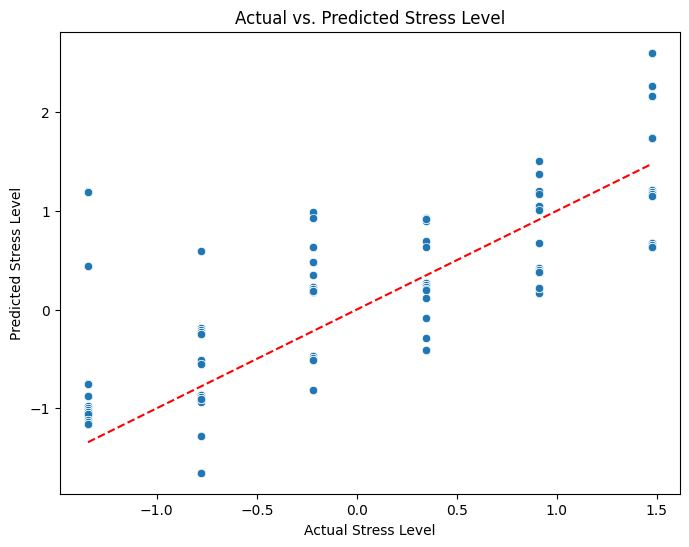

In [23]:
predicted_values = final_model.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=predicted_values)
plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.title("Actual vs. Predicted Stress Level")
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')  # 45-degree reference line
plt.show()

## Random Forest Classification